In [292]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import sqlalchemy as sqla
df_nArticlesPerUser = pd.read_pickle("./dummy.pkl")

In [293]:
df_nArticlesPerUser

,ID_User,Beitrag
0,28526,Das ist eine Schicht von mehreren 1000 möglich...
1,28526,wird das dann wie bei den arbeitszeugnissen we...
2,28526,naja ein bisserl mehr als 10-20 prozent der be...
3,28526,Wobei ich das Beispiel der Mindestsicherung oh...
4,28526,"Also wenn es einen Narrativ in Hollywood gibt,..."
...,...,...
795,18006,"Europa zu einem ""melting pot"" zu machen mit Ku..."
796,18006,Jeder männliche Afghane ist verpflichtet einen...
797,18006,Man muss die Flüchtlinge nur bis an die türkis...
798,18006,"Nein, die islamistische Terrorgruppe ""Islamisc..."


In [294]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=15)
features = tfidf.fit_transform(df_nArticlesPerUser.Beitrag).toarray()
labels = df_nArticlesPerUser.ID_User
features.shape

(800, 409)

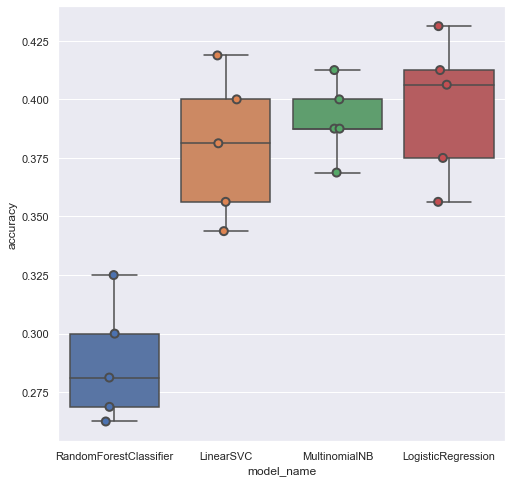

In [295]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
import seaborn as sns

models = [
RandomForestClassifier(n_estimators=100),
LinearSVC(),
MultinomialNB(),
LogisticRegression(),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy',cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

plt.figure(figsize=(8,8))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
sns.set(rc={"figure.figsize":(3, 4)})
plt.show()

In [296]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.38000
LogisticRegression        0.39625
MultinomialNB             0.39125
RandomForestClassifier    0.28750
Name: accuracy, dtype: float64

In [297]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import *

In [321]:
def calculate_top5accuracy(df):
    acc = []
    for j in range(0, len(prediction_probs)):
        pre_probs = df.iloc[j]
        pre_probs_indices = pre_probs.nlargest(5).index
        if pre_probs.name in pre_probs_indices:
            acc.append(1)
        else:
            acc.append(0)

    return round(((acc.count(1) * 100) / len(acc)), 2)

def evaluate(model):
    results = []
    accuracies, precisions, recalls, fscores, top5accuracies, y_tests, y_preds = [], [], [], [], [], [], []

    for i in range(6):
        X_train, X_test, y_train, y_test =train_test_split(features, labels, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = (round(accuracy_score(y_test, y_pred) * 100, 2)) 
        precision = (round(precision_score(y_test, y_pred, average='macro', zero_division=0) * 100, 2))
        recall = (round(recall_score(y_test, y_pred, average='macro') * 100, 2))
        fscore = (round(f1_score(y_test, y_pred, average='macro') * 100, 2))
        df = pd.DataFrame(model.predict_proba(X_test), columns=model.classes_, index=y_test)
        top5accuracy = (calculate_top5accuracy(df))
        matrix = (confusion_matrix(y_test, y_pred))
    
        results.append((accuracy,precision,recall,fscore,top5accuracy,matrix))
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        fscores.append(fscore)
        top5accuracies.append(top5accuracy)
        matrices.append(matrix)
        y_preds = np.append(y_preds, y_pred)
        y_tests = np.append(y_tests, y_test)

    combined_matrix = confusion_matrix(y_tests, y_preds)
    print("Top-5 Test Accuracy: %.2f\nTest Accuracy: %.2f\nTest Precision: %.2f\nTest Recall: %.2f\nTest Fscore: %.2f" % (
        np.mean(top5accuracies), np.mean(accuracies), np.mean(precisions), np.mean(recalls), np.mean(fscores)))

    fname= './Plots/Combined Matrices for ' + model.__class__.__name__ + '.png'
    plt.figure(figsize=(8,8))
    ax = sns.heatmap(combined_matrix, annot=True, fmt='d', xticklabels=model.classes_, yticklabels=model.classes_)
    ax.set(title=('Combined Matrices for ' + model.__class__.__name__),
          xlabel="Predicted",
          ylabel="Actual",)
    sns.set()
    plt.savefig(fname)
    return results, model

Top-5 Test Accuracy: 61.46
Test Accuracy: 27.81
Test Precision: 27.10
Test Recall: 30.41
Test Fscore: 26.32


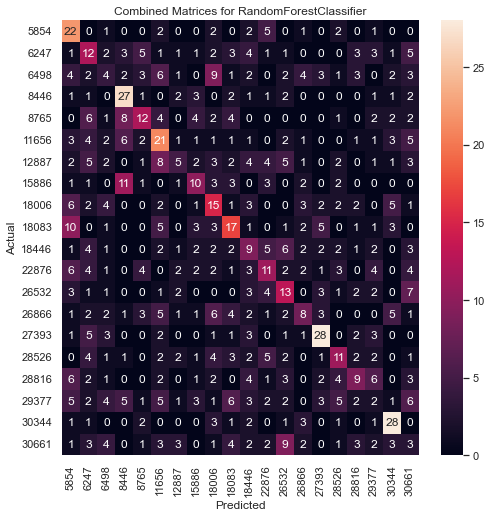

In [322]:
RandomForestClassifierResults = evaluate(RandomForestClassifier(n_estimators=100))

Top-5 Test Accuracy: 75.73
Test Accuracy: 35.62
Test Precision: 38.21
Test Recall: 37.24
Test Fscore: 35.12


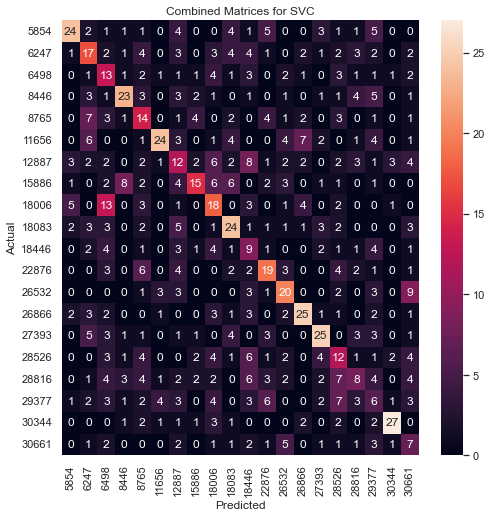

In [323]:
from sklearn.svm import SVC
#AttributeError: 'LinearSVC' object has no attribute 'predict_proba'
#oder clf._predict_proba_lr(X_test,Y_test)
LinearSVCResults = evaluate(SVC(kernel="linear", probability=True))

Top-5 Test Accuracy: 66.15
Test Accuracy: 30.42
Test Precision: 36.09
Test Recall: 34.37
Test Fscore: 28.68


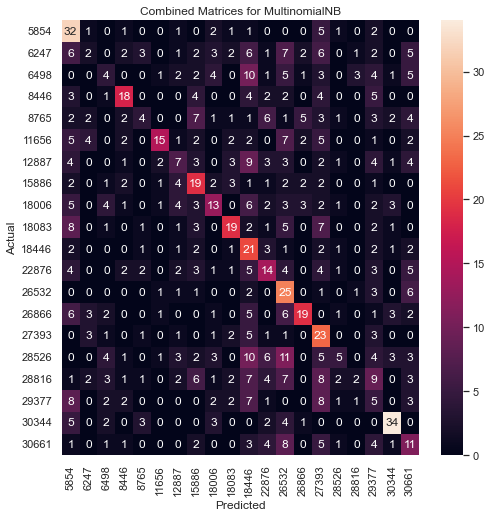

In [324]:
MultinomialNBResults = evaluate(MultinomialNB())

Top-5 Test Accuracy: 73.75
Test Accuracy: 36.87
Test Precision: 40.25
Test Recall: 39.05
Test Fscore: 35.63


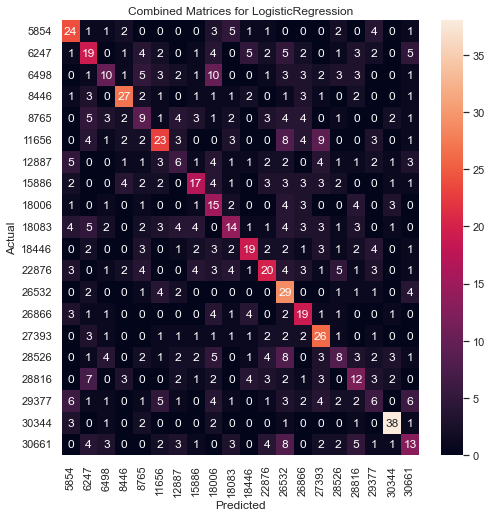

In [325]:
LogisticRegressionResults = evaluate(LogisticRegression())

In [328]:
def plot_confusionMatrices(results):
    runs,model = results
    fname= './Plots/ConfusionMatricesFor6RunsWith ' + model.__class__.__name__ + '.png'
    plt.figure(figsize=(20,30))
    x = 1
    for run in runs:
        accuracy,precision,recall,fscore,top5accuracy,matrix = run
        plt.subplot(3,2,x)
        ax = sns.heatmap(matrix, annot=True, fmt='d', xticklabels=model.classes_, yticklabels=model.classes_)
    
        ax.set(title=("Run " + str(x) + '\n Accuracy: ' + str(accuracy) + ' Precision: ' + str(precision) + ' Recall: ' + str(recall) + ' Fscore: ' + str(fscore) + ' Top5Accuracy: ' + str(top5accuracy)),
          xlabel=('Predicted'),
          ylabel="Actual",)
        x+=1
    sns.set()
    plt.savefig(fname)

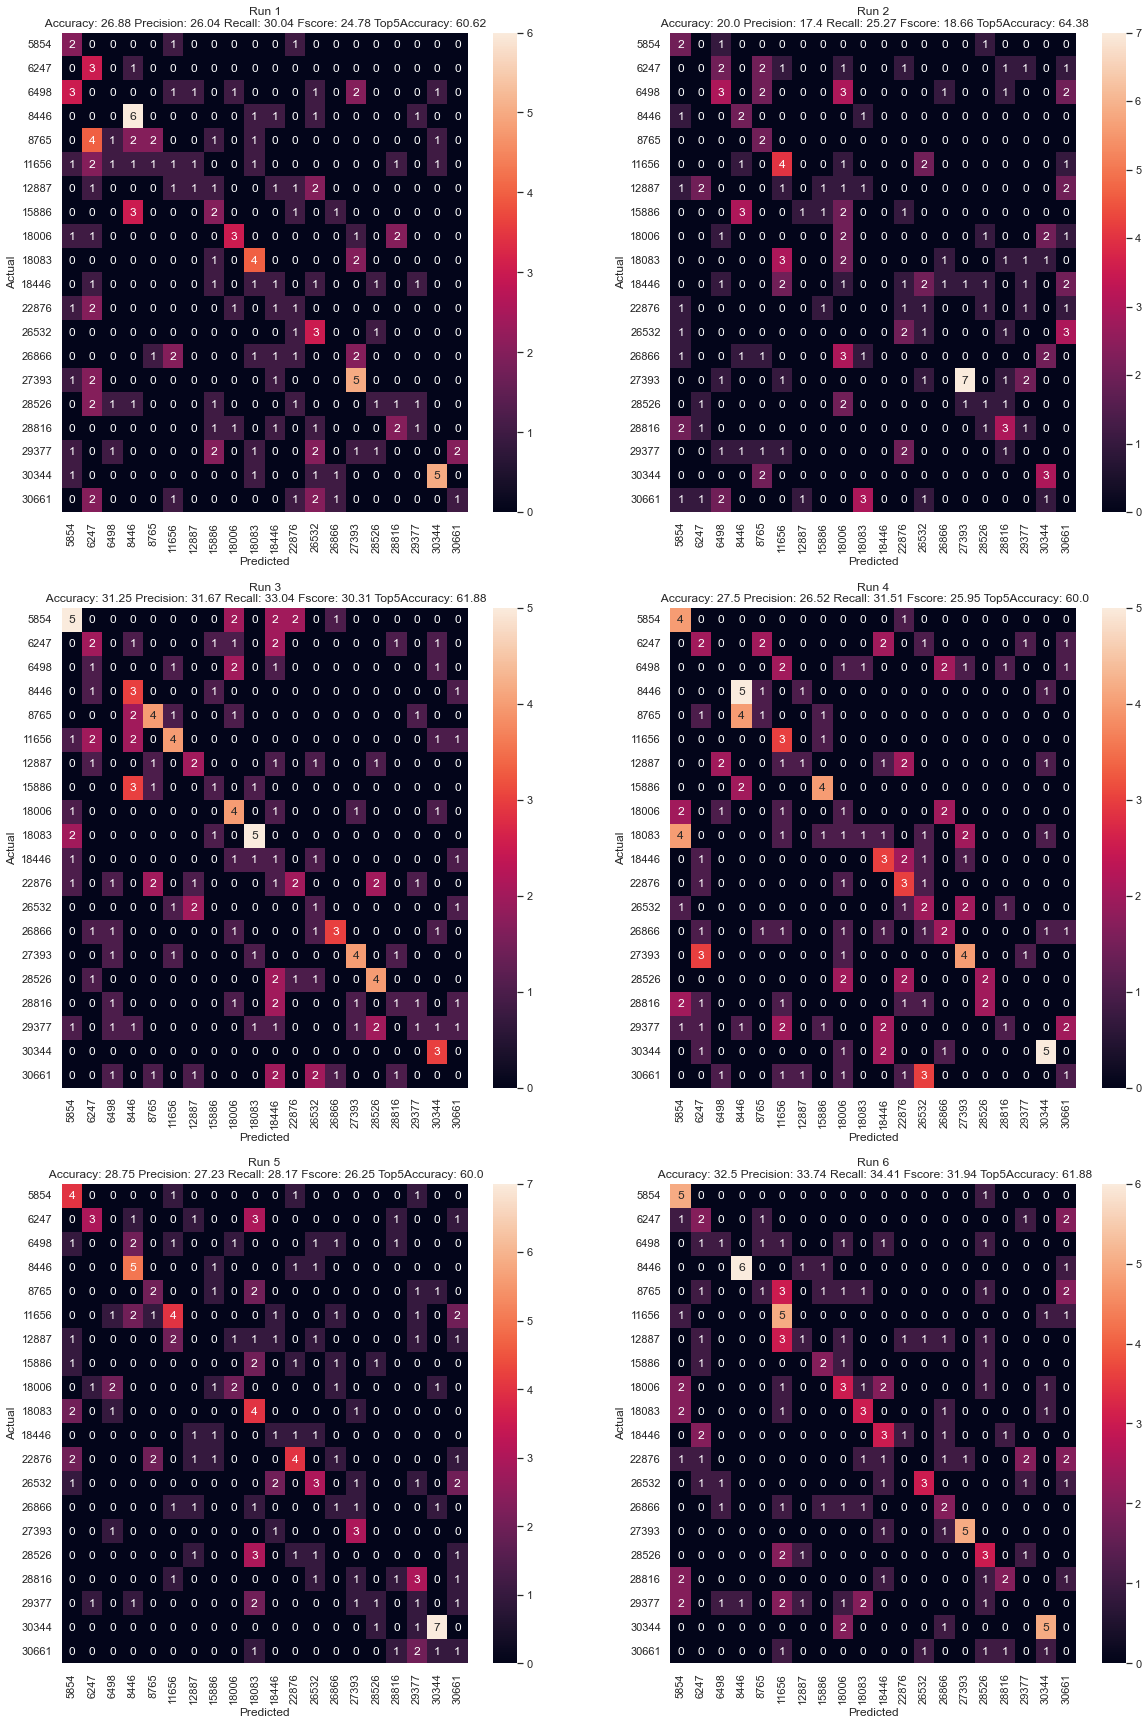

In [329]:
plot_confusionMatrices(RandomForestClassifierResults)

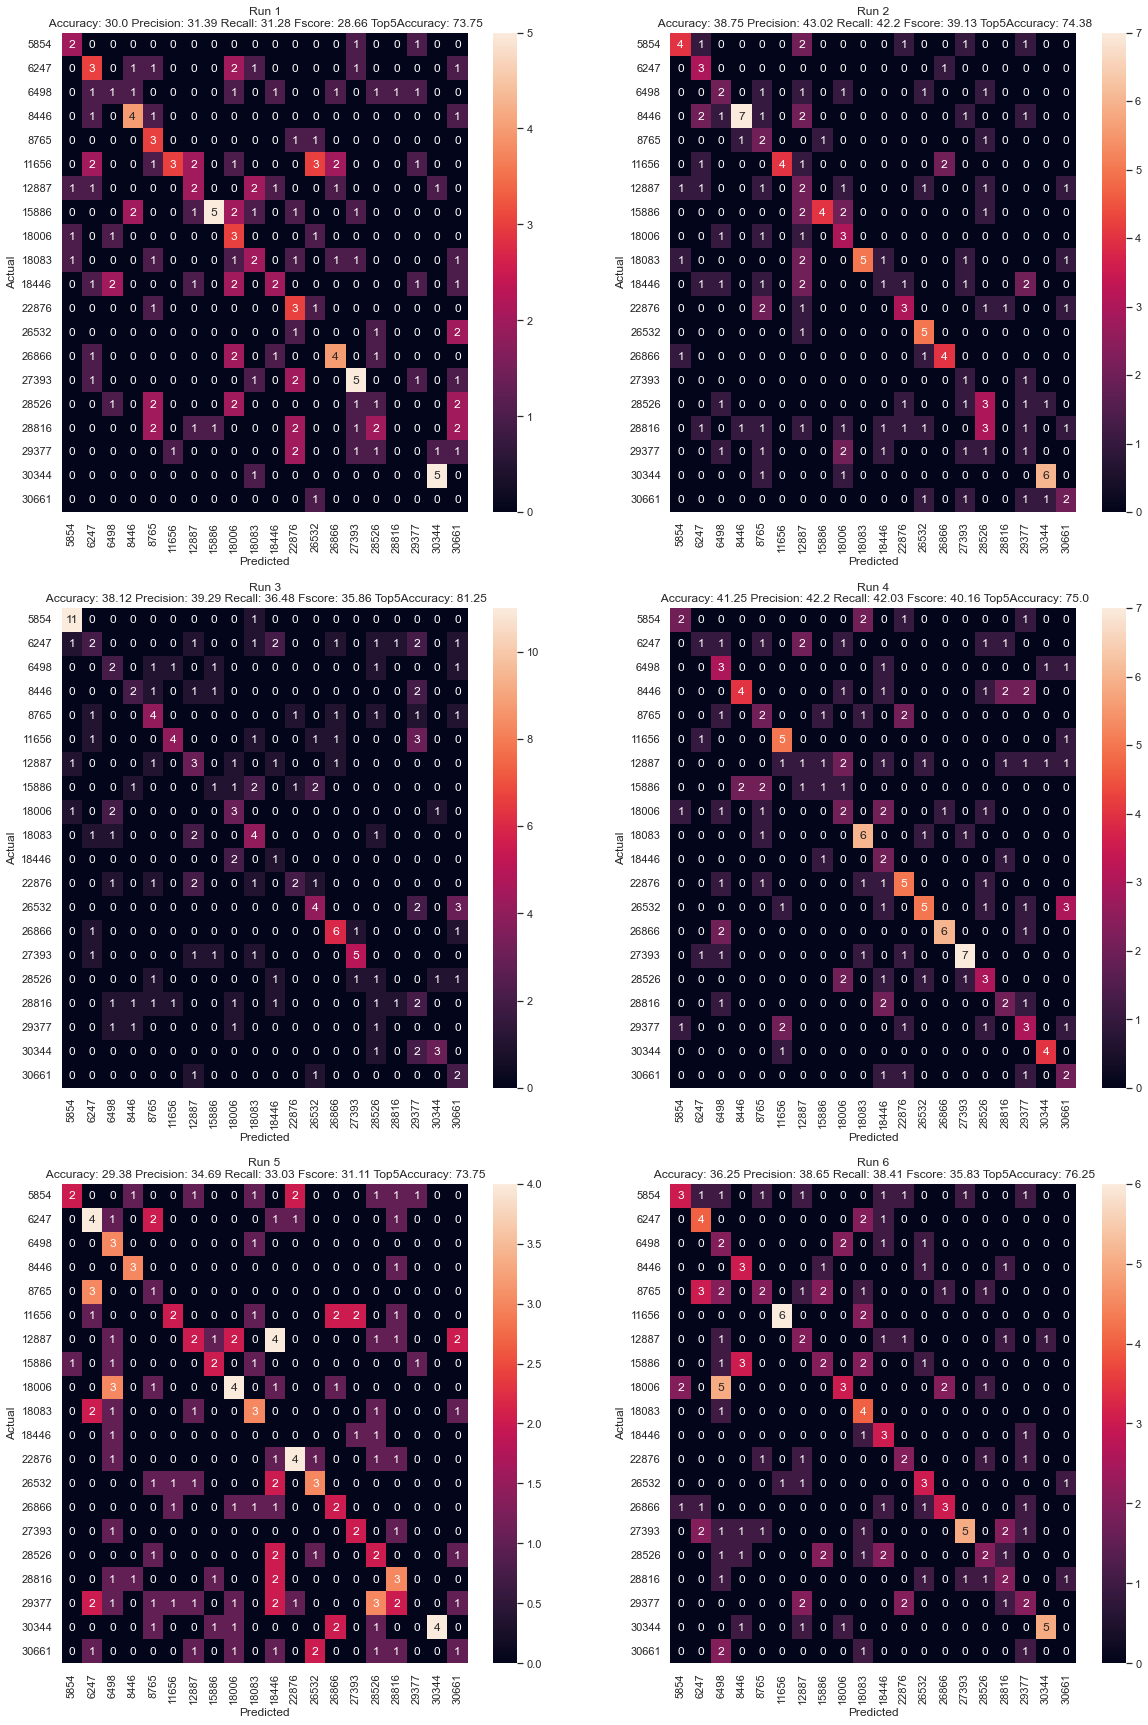

In [330]:
plot_confusionMatrices(LinearSVCResults)

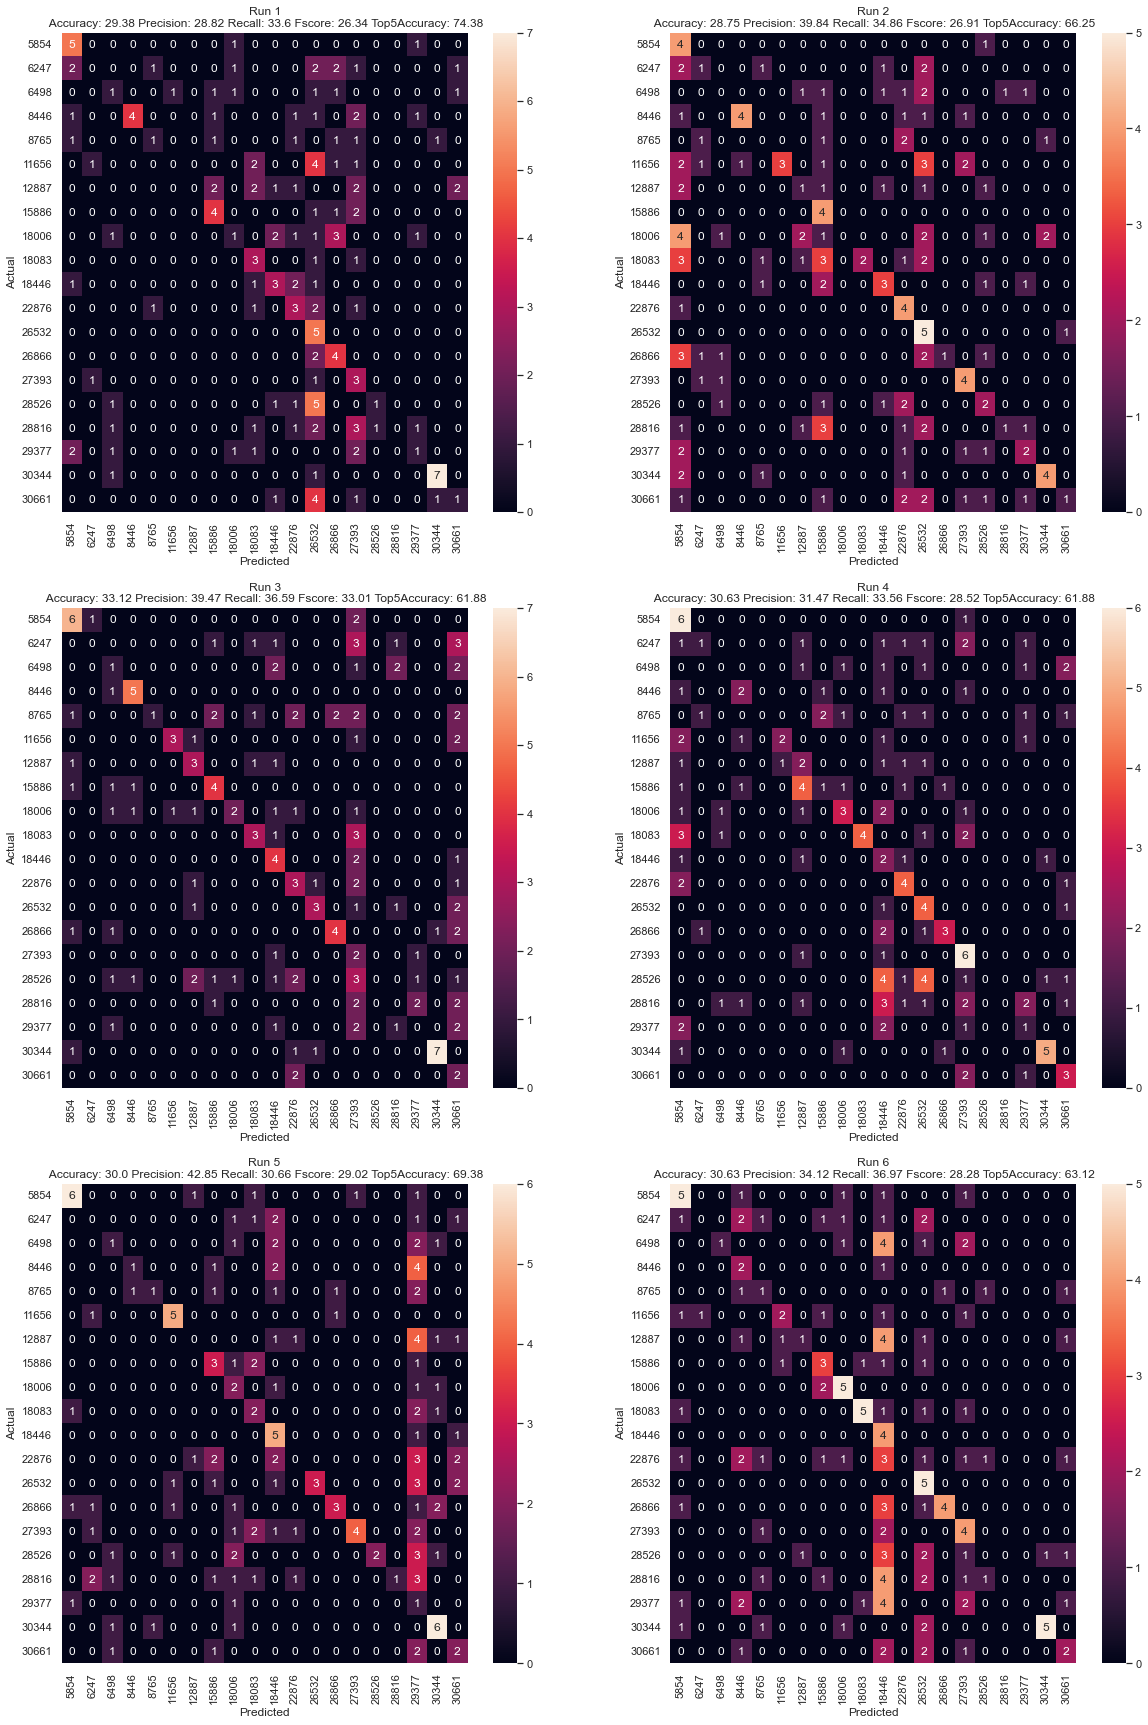

In [331]:
plot_confusionMatrices(MultinomialNBResults)

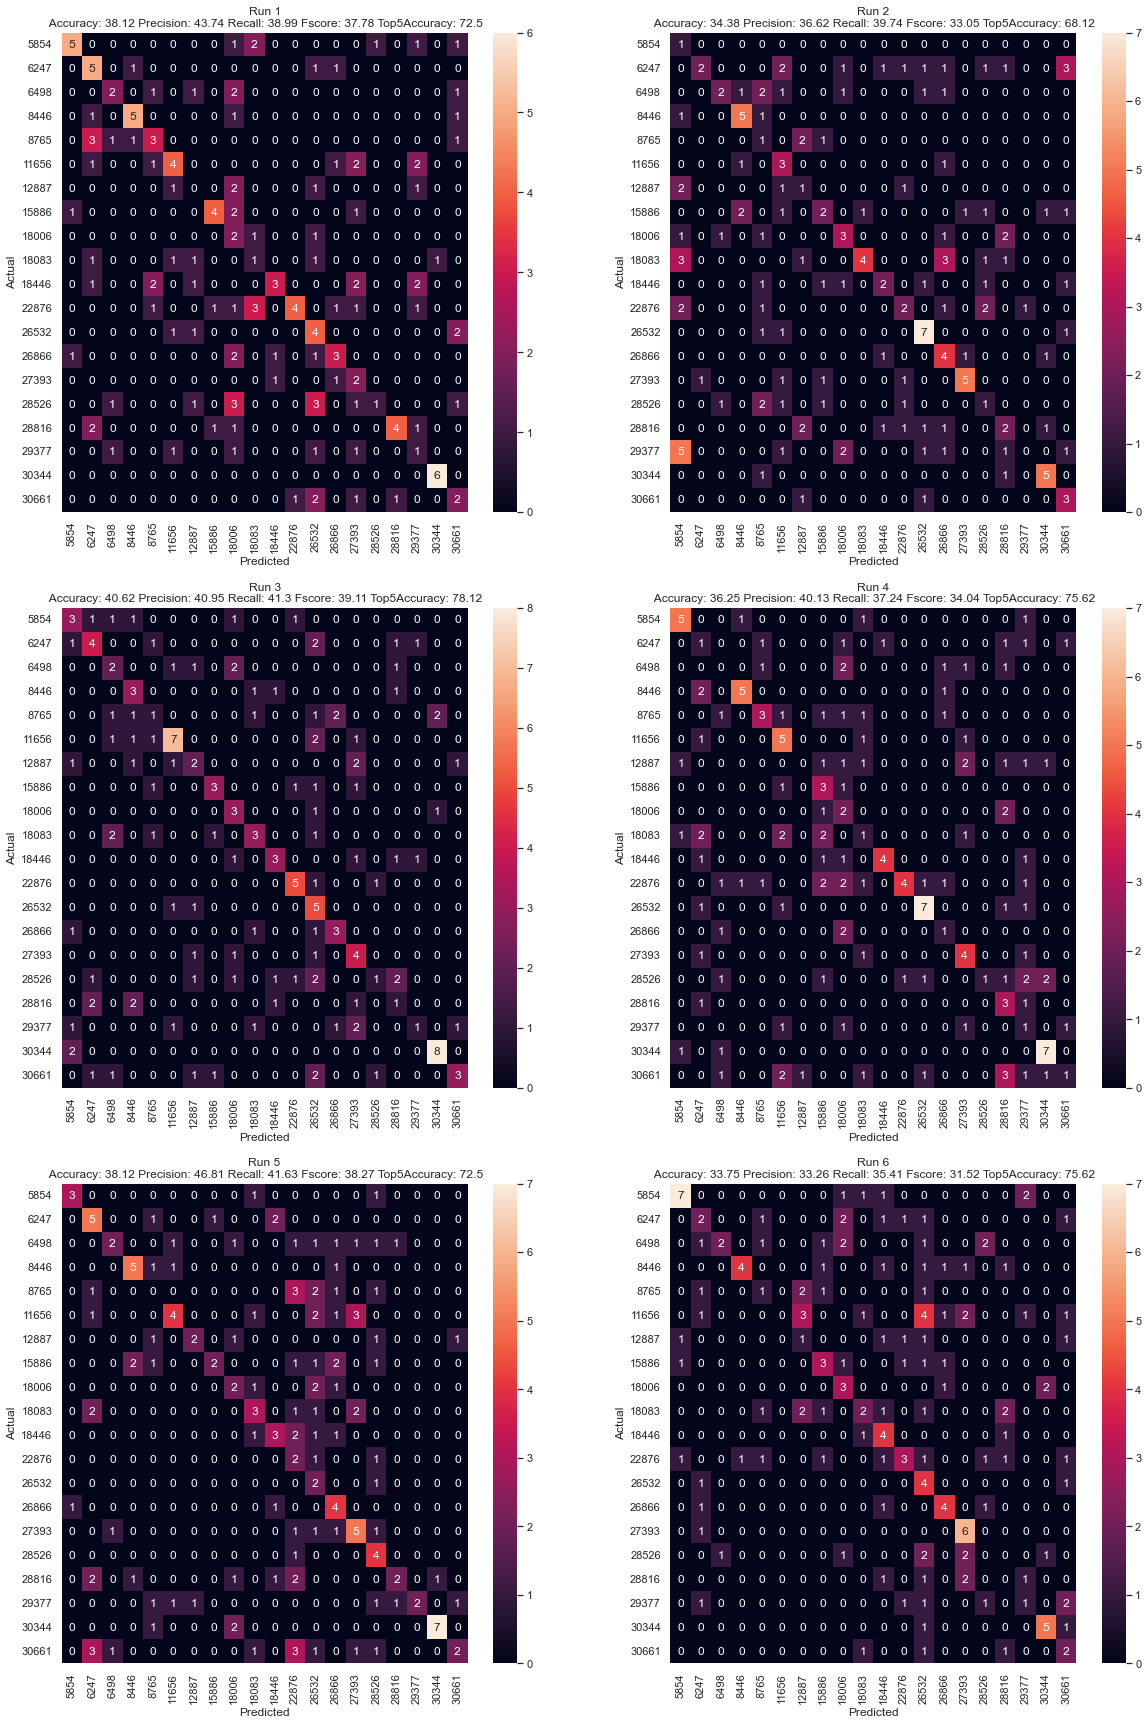

In [332]:
plot_confusionMatrices(LogisticRegressionResults)